# Rozpoznawanie komórek krwi na zdjęciach przy pomocy AI

In [2]:
# Importowanie modułów

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2025-02-25 14:36:19.808567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 14:36:19.845353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 14:36:20.584531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


## Wczytywanie zbioru danych

Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


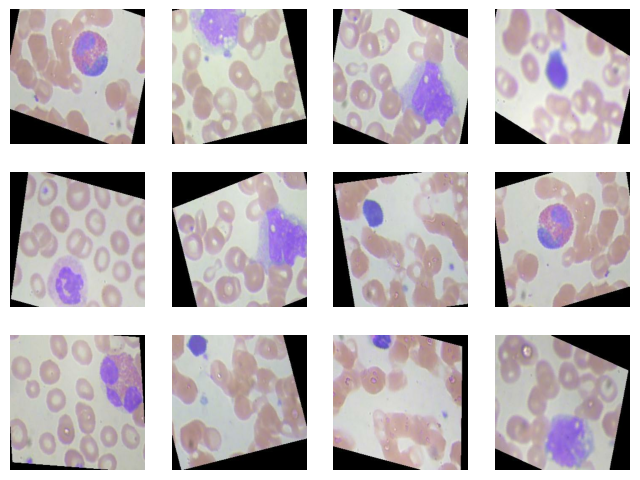

2025-02-25 15:08:25.181367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Parametry
IMG_SIZE = (320, 240)
TARGET_SIZE = (240, 240)
BATCH_SIZE = 32
TRAIN_DIR = "images/TRAIN"
TEST_DIR = "images/TEST"

# Wczytanie zbioru treningowego
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Wczytanie zbioru testowego
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Normalizacja wartości pikseli do [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Podgląd danych
plt.figure(figsize=(8,6))
for images, labels in train_dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


## 🧠 Budowa modelu CNN do klasyfikacji komórek krwi

Teraz stworzymy **konwolucyjny model sieci neuronowej (CNN)**, który nauczy się rozpoznawać typy komórek na podstawie zdjęć.  
Model składa się z kilku warstw:

1. **Warstwy konwolucyjne (`Conv2D`)** – wykrywają wzorce na obrazach, np. kształty komórek.  
2. **Warstwy `MaxPooling2D`** – zmniejszają rozmiar obrazu, aby uprościć obliczenia.  
3. **Warstwa `Flatten`** – przekształca obraz w wektor cech.  
4. **Warstwa gęsta (`Dense`)** – uczy się rozpoznawać kategorie komórek.  
5. **Warstwa wyjściowa (`Dense(4, activation='softmax')`)** – zwraca prawdopodobieństwa dla 4 klas.  

Funkcja aktywacji **ReLU** przyspiesza uczenie, a **Dropout (0.5)** zapobiega przeuczeniu modelu.  


In [31]:


model = tf.keras.Sequential([
    layers.Conv2D(64, (8,8), activation='relu', input_shape=(240, 240, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 233, 233, 64)   │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 233, 233, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 116, 116, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 112, 112, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 54, 54, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 54, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,458,500 (47.53 MB)

 Trainable params: 12,457,604 (47.52 MB)

 Non-trainable params: 896 (3.50 KB)

## 🚀 Trenowanie modelu na danych komórek krwi

Model zostanie nauczony na zbiorze treningowym przez 20 epok.  
Podczas każdej epoki:
- Model przeanalizuje dane i dostosuje swoje wagi.
- Sprawdzimy jego skuteczność na zbiorze walidacyjnym.

Na koniec zapisujemy wytrenowany model (`.h5`), aby później można było go załadować i użyć do klasyfikacji nowych zdjęć.  


In [32]:
EPOCHS = 2

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model.save("blood_cell_classifier.h5")


Epoch 1/2
312/312 ━━━━━━━━━━━━━━━━━━━━ 1075s 3s/step - accuracy: 0.2512 - loss: 3.0065 - val_accuracy: 0.2485 - val_loss: 2.9974
Epoch 2/2
312/312 ━━━━━━━━━━━━━━━━━━━━ 1115s 4s/step - accuracy: 0.2436 - loss: 1.3899 - val_accuracy: 0.2622 - val_loss: 4.8385
